In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy.integrate import odeint, ode
import scipy.stats as st
import matplotlib.pyplot as plt
from helper_functions import *

In [3]:
consts = {}

# Physical constants and conversion factors
Na   = 6.0221415e23      # 1/mol
kb   = 8.6173303e-5      # eV/K
T    = 300               # K
h    = 6.5821195e-16     # eV*s
kbT  = kb * T            # eV
kbTh = kbT / h           # 1/s


# Material properties
dens_H2O =  0.997        # g / cm^3, at 300 K
mw_H2O   = 18.015        # g / mol


# System assumptions
No   = (9 / (8.415900 * 7.288383)) * (1e10)**2  # sites/Angstroms^2 * Angstroms^2/m^2 = sites/m^2
Acat = 2.00e+05          # m^2/kg
W    = 5.64e-02          # L/kg
mass = 3.00e-04 * 0.043  # kg * wt% Pt

V    = 5.32e-3           # L
v0   = 8.33e-6           # L/s
tau  = V / v0            # s (residence time)

pH   = 7.0

In [4]:
# Define the reactions

# Rxn 1: COH* + *           -----> CO* + H*            # Direct COH* dehydrogenation
# Rxn 2: COH* + H2O(aq)     -----> COH-H2O*            # COH-H2O* complexation
# Rxn 3: COH-H2O* + *       -----> CO* + H* + H2O(aq)  # H2O-co-catalyzed COH* dehydrogenation
# Rxn 4: COH-H2O* + H2O(aq) -----> COH-H2O-H2O*        # COH-H2O-H2O* complexation
# Rxn 5: COH-H2O-H2O*       -----> CO* + H5O2(aq)      # H2O-assisted COH* dehydrogenation
# Rxn 6: H5O2(aq) + *       -----> H* + 2 H2O(aq)      # H5O2* dehydrogenation

# Define a dictionary for all the species name strings

species_dict = {0: r'H$_2$O(aq)',
                1: r'H$_5$O$_2$(aq)',
                2: r'COH*',
                3: r'CO*',
                4: r'H*',
                5: r'COH-H$_2$O*',
                6: r'COH-H$_2$O-H$_2$O*',
                7: r'*'}

In [5]:
# The stoichiometry matrix for the reactions including liquid H2O and H5O

# Reaction       1   2   3   4   5   6
s = np.matrix([[ 0, -1,  1, -1,  0,  2],   # H2O(aq)
               [ 0,  0,  0,  0,  1, -1],   # H5O2(aq)
               [-1, -1,  0,  0,  0,  0],   # COH*
               [ 1,  0,  1,  0,  1,  0],   # CO*
               [ 1,  0,  1,  0,  0,  1],   # H*
               [ 0,  1, -1, -1,  0,  0],   # COH-H2O*
               [ 0,  0,  0,  1, -1,  0],   # COH-H2O-H2O*
               [-1,  0, -1,  0,  0, -1]])  # *

In [6]:
def get_Erxns(random=False):

    # Reaction           1      2      3      4      5      6
    Erxn = np.array([ 0.10, -0.52,  0.61,  0.01, -0.10,  0.20])
    Err  = np.array([ 0.08,  0.26,  0.39,  0.34,  0.15,  0.14])

    if random is True:
        Erxn = np.random.normal(Erxn, Err/1.96)

    return Erxn


In [7]:
def get_Eacts(random=False):

    # Reaction           1      2      3      4      5      6
    Eact = np.array([ 1.68,  0.00,  0.61,  0.01,  0.00,  0.20])
    Err  = np.array([ 0.18,  0.10,  0.36,  0.10,  0.10,  0.10])

    if random is True:
        Eact = np.absolute(np.random.normal(Eact, Err/1.96))

    return Eact


In [8]:
def get_As(random=False):

    # Reaction            1        2        3        4        5        6
    Af  = np.array([6.25e12, 6.75e12, 4.04e12, 9.87e10, 4.04e12, 6.25e12])
    Err = np.array([0.10e12, 0.10e12, 0.10e12, 0.10e09, 0.10e12, 0.10e12])

    if random is True:
        Af = np.random.normal(Af, Err/1.96)

    return Af


In [9]:
def get_ks(Erxn, Eact, Af):

    Keq  = np.exp(-Erxn / kbT)
    kf  = Af * np.exp(-Eact / kbT)
    kr  = kf / Keq

    return Keq, kf, kr


In [11]:
def get_rates(z, kf, kr):

    # (0) H2O(aq)
    # (1) H5O2(aq)
    # (2) COH*
    # (3) CO*
    # (4) H*
    # (5) COH-H2O*
    # (6) COH-H2O-H2O*
    # (7) *

    Nsites = No * Acat / Na
    
#     rf = np.array([[kf[0] * z[2] * z[7]       ],  # Rxn 1
#                    [kf[1] * z[2] * z[0]       ],  # Rxn 2
#                    [kf[2] * z[5] * z[7]       ],  # Rxn 3
#                    [kf[3] * z[5] * z[7]       ],  # Rxn 4
#                    [kf[4] * z[6]              ],  # Rxn 5
#                    [kf[5] * z[1] * z[7]       ]]) # Rxn 6

#     rr = np.array([[kr[0] * z[3] * z[4]       ],  # Rxn 1
#                    [kr[1] * z[5]              ],  # Rxn 2
#                    [kr[2] * z[3] * z[4] * z[0]],  # Rxn 3
#                    [kr[3] * z[6]              ],  # Rxn 4
#                    [kr[4] * z[3] * z[1]       ],  # Rxn 5
#                    [kr[5] * z[4] * z[0]**2    ]]) # Rxn 6
    
    rf = np.array([[kf[0] * z[2] * z[7]       ],  # Rxn 1
                   [kf[1] * z[2] * z[0]       ],  # Rxn 2
                   [kf[2] * z[5] * z[7]       ],  # Rxn 3
                   [kf[3] * z[5] * z[7]       ],  # Rxn 4
                   [kf[4] * z[6]              ],  # Rxn 5
                   [kf[5] * z[1] * z[7]       ]]) # Rxn 6

    rr = np.array([[kr[0] * z[3] * z[4]       ],  # Rxn 1
                   [kr[1] * z[5]              ],  # Rxn 2
                   [kr[2] * z[3] * z[4] * z[0]],  # Rxn 3
                   [kr[3] * z[6]              ],  # Rxn 4
                   [kr[4] * z[3] * z[1]       ],  # Rxn 5
                   [kr[5] * z[4] * z[0]**2    ]]) # Rxn 6
    
    r = rf - rr

    return r, rf, rr
    

In [ ]:
def reactor_model(model='CSTR'):
    
    if model is 'Batch':
        dCdt = r
    
    if model is 'CSTR':
        dCdt = (C0 - C)* v0/V + r
        
    return dFdt

In [12]:
def mkm(z, t, kf, kr, s, model='CSTR'):

    r, rf, rr = get_rates(z, kf, kr)

    dNdt = np.array(np.dot(s, r))

    if model is 'CSTR':
        dNdt = dNdt[:,0] * W
        dz = dNdt*(No*Acat/Na)

    return dz


In [13]:
def run_mkm(z0, s, sim_time, timestep, random=False, iterations=100):

    y_cumulative = []

    for i in range(iterations):

        Erxn = get_Erxns(random=random)
        Eact = get_Eacts(random=random)
        Af   = get_As(random=random)
        Keq, kf, kr = get_ks(Erxn, Eact, Af)

        t = np.arange(0, sim_time, timestep)
        
        y = odeint(mkm, z0, t, args=(kf, kr, s), h0=1e-36, atol=1e-13, rtol=1e-13, mxstep=1000000, mxords=5)
        # y = odeint(mkm, z0, t, args=(kf, kr, s))

        y_cumulative.append(y)

    y, pos_err, neg_err = avg_and_error(y_cumulative)

    return y, pos_err, neg_err, t


In [14]:
C0 = np.zeros(8)

Q0 = np.zeros(8)


In [16]:
# Define the initial concentrations

# C0[0] = C_H2O is obtained from the density of liquid H2O at 300 K
# C0[1] = C_H5O2 is obtained from the pH ([H5O2] = [H] = 10^(-pH))

C0[0] = dens_H2O / mw_H2O * 1000  # conc( H2O(aq)      ) [mol/L]
C0[1] = np.power(10, -pH)            # conc( H5O2(aq)     ) [mol/L]
C0[2] = 0.0000e+00                   # conc( COH*         ) [mol/L]
C0[3] = 0.0000e+00                   # conc( CO*          ) [mol/L]
C0[4] = 0.0000e+00                   # conc( H*           ) [mol/L]
C0[5] = 0.0000e+00                   # conc( COH-H2O*     ) [mol/L]
C0[6] = 0.0000e+00                   # conc( COH-H2O-H2O* ) [mol/L]
C0[7] = 0.0000e+00                   # conc( *            ) [mol/L]


# Define the initial surface coverages

Q0[0] = 0.0000e+00                   # theta( H2O(aq)      )
Q0[1] = 0.0000e+00                   # theta( H5O2(aq)     )
Q0[2] = 0.9000e+00                   # theta( COH*         )
Q0[3] = 0.0500e+00                   # theta( CO*          )
Q0[4] = 0.0000e+00                   # theta( H*           )
Q0[5] = 0.0000e+00                   # theta( COH-H2O*     )
Q0[6] = 0.0000e+00                   # theta( COH-H2O-H2O* )
Q0[7] = 1 - np.sum(Q0[:-1])          # theta( *            )


# C0[0] = 1.6569e-05
# C0[1] = 1.8666e-02
# C0[2] = 0.0000e+00
# C0[3] = 0.0000e+00
# C0[4] = 0.0000e+00
# C0[5] = 0.0000e+00
# C0[6] = 0.0000e+00
# C0[7] = 0.0000e+00

# Q0[0] = 0.0000e+00
# Q0[1] = 0.0000e+00
# Q0[2] = 2.3975e-02
# Q0[3] = 8.3970e-01
# Q0[4] = 3.5531e-02
# Q0[5] = 7.8998e-02
# Q0[6] = 7.3292e-03
# Q0[7] = 1.4469e-02


In [17]:
# Convert initial concentrations into initial molar flow rates

F0 = C0 * v0                         # [mol/s] = [mol/L] * [L/s]


# Convert intial flow rates and coverages to mols

x0 = np.zeros(8)
x0[:2] = F0[:2] / v0                 # [mol/V] = [mol/s] / [V/s]
x0[2:] = Q0[2:] * (No * Acat / Na)   # [mol/V] = [molecules/site] * ([sites/A] * [A/V] / [molecules/mol])


In [18]:
# Set up and solve the differential equations
sim_time = 1.00e-08
timestep = 1.00e-12

y, pos_err, neg_err, t = run_mkm(x0, s, sim_time, timestep, random=True, iterations=100)

y[:2]       *= v0
pos_err[:2] *= v0
neg_err[:2] *= v0

y[2:]       *= Na / (No * Acat)
pos_err[2:] *= Na / (No * Acat)
neg_err[2:] *= Na / (No * Acat)

/home/cbodens/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1910: RuntimeWarning: invalid value encountered in multiply
  lower_bound = self.a * scale + loc
/home/cbodens/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1911: RuntimeWarning: invalid value encountered in multiply
  upper_bound = self.b * scale + loc


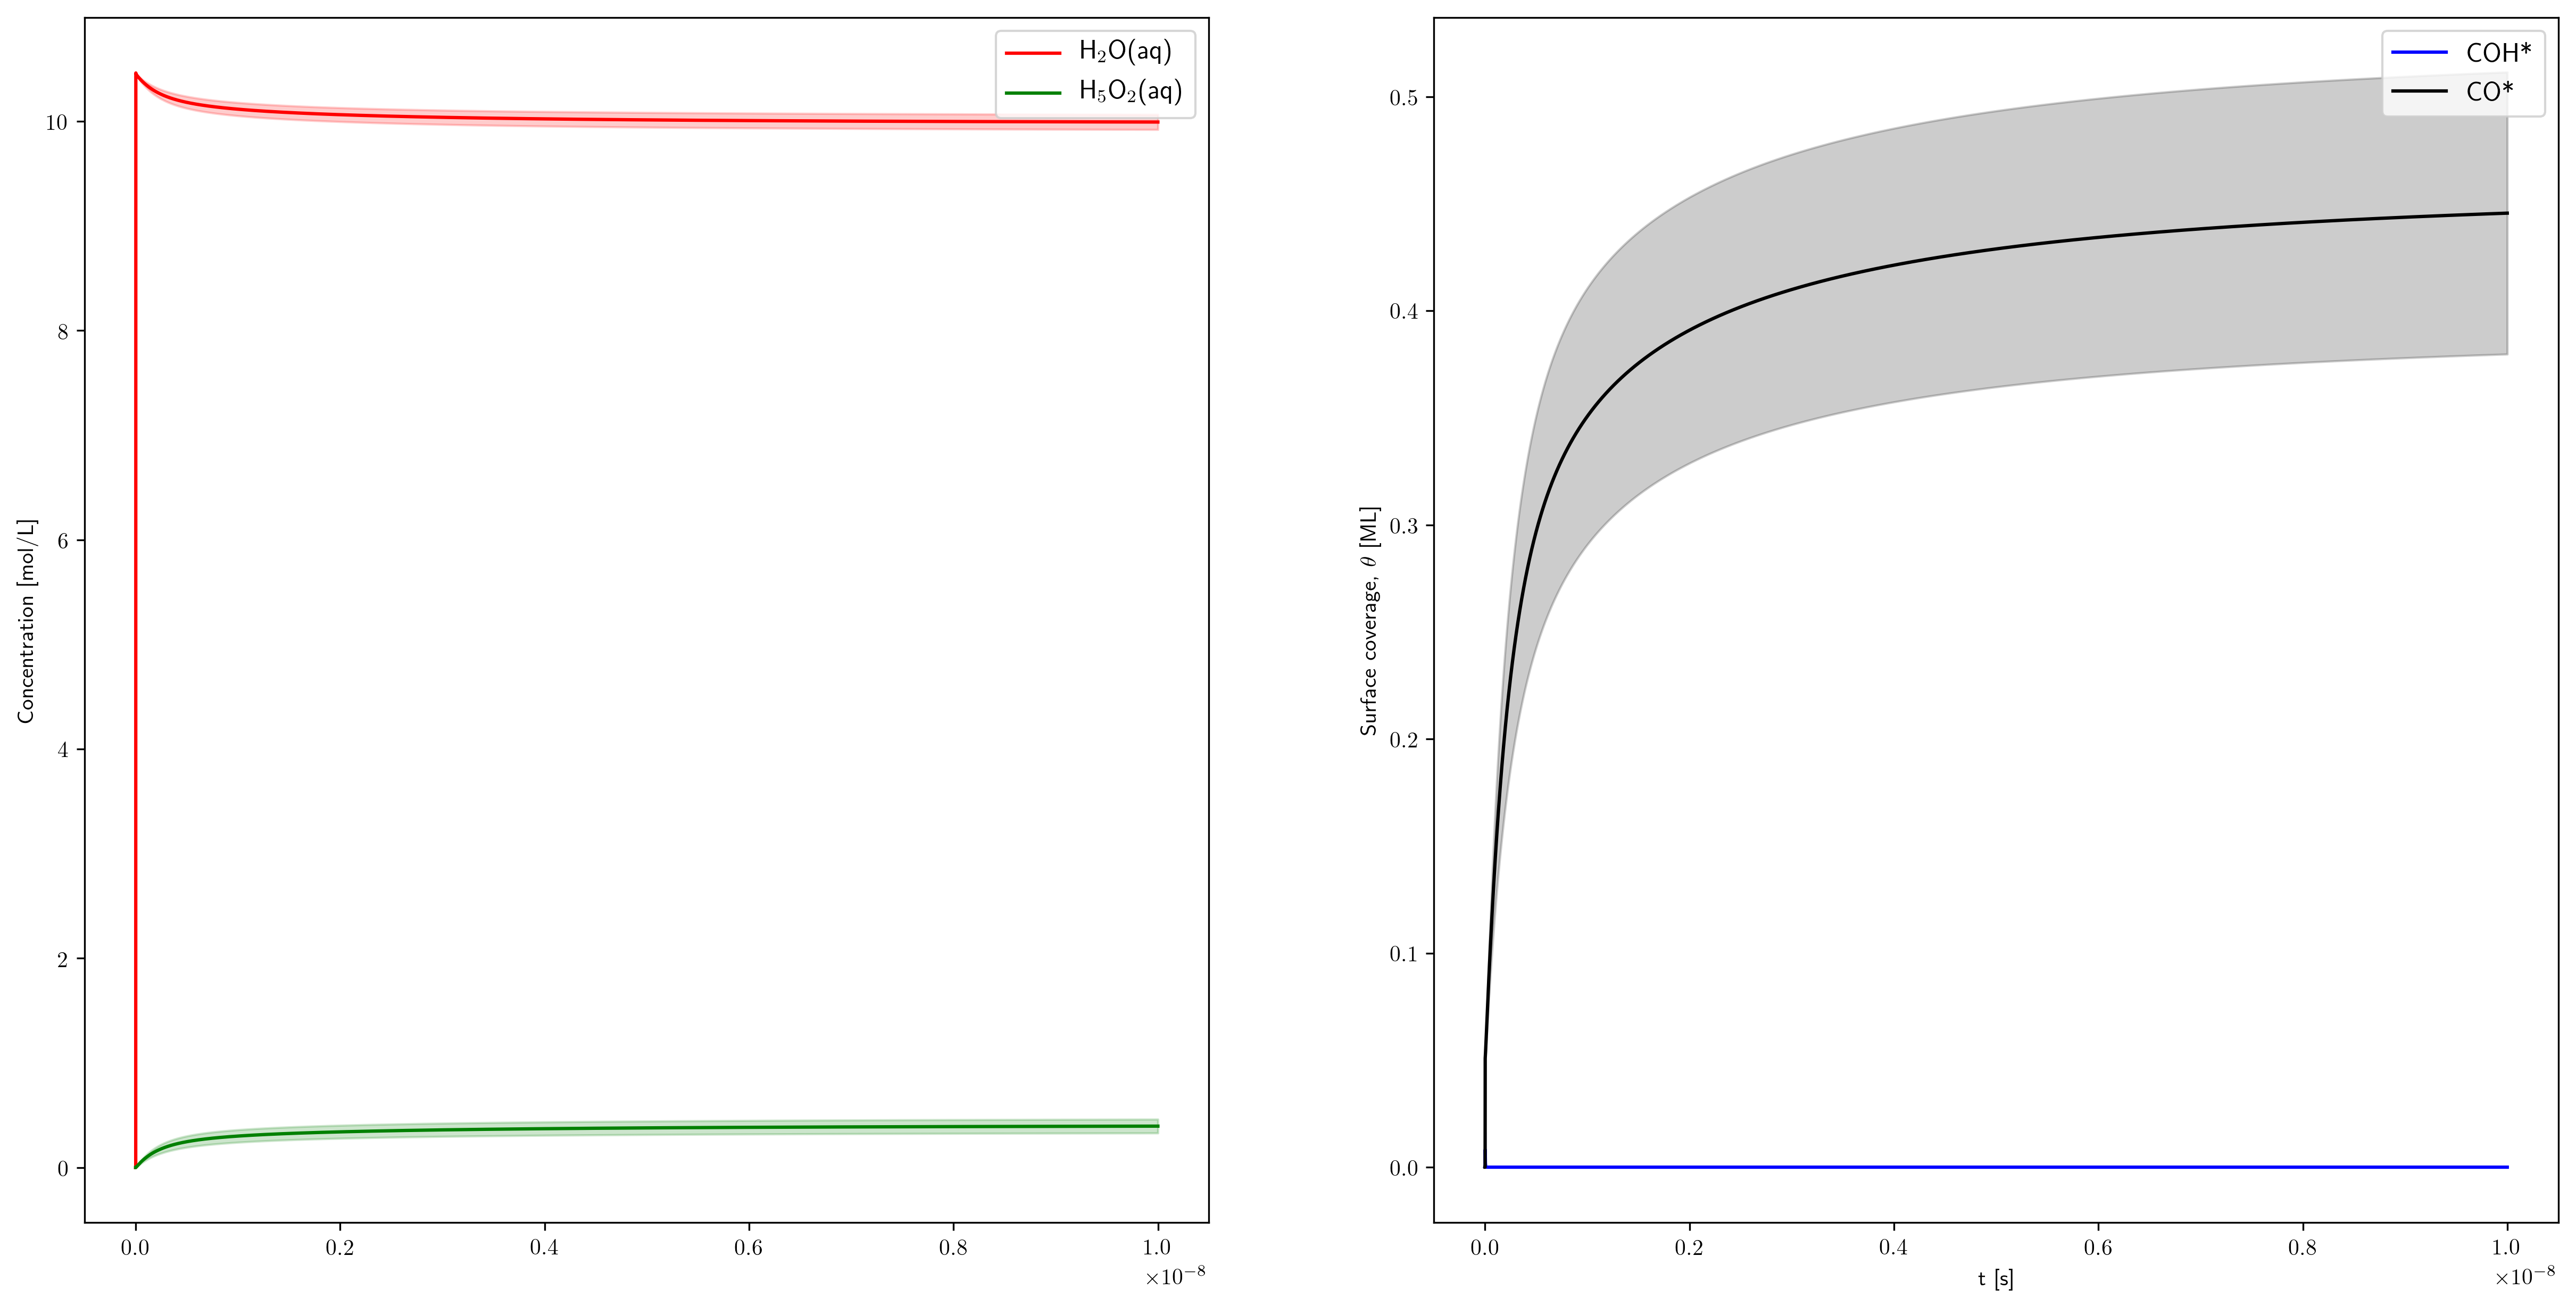

In [19]:
# plot_list  = [0, 1, 2, 3, 4, 5, 6]
plot_list = [0,1,2,3]
color_dict = {0: 'r', 1: 'g', 2: 'b', 3: 'k', 4: 'm', 5: 'c', 6: 'y', 7: 'w'}

plot_results(plot_list, species_dict, color_dict, y, pos_err, neg_err, t)

In [20]:
for index in range(len(y[-1])):
    if index < 2:
        print('C0[{:d}] = {:.4e}'.format(index, y[-1][index]))
    else:
        print('C0[{:d}] = {:.4e}'.format(index, 0.0))
        
print()

for index in range(len(y[-1])):
    if index < 2:
        print('Q0[{:d}] = {:.4e}'.format(index, 0.0))
    else:
        print('Q0[{:d}] = {:.4e}'.format(index, y[-1][index]))

C0[0] = 9.9939e+00
C0[1] = 3.9558e-01
C0[2] = 0.0000e+00
C0[3] = 0.0000e+00
C0[4] = 0.0000e+00
C0[5] = 0.0000e+00
C0[6] = 0.0000e+00
C0[7] = 0.0000e+00

Q0[0] = 0.0000e+00
Q0[1] = 0.0000e+00
Q0[2] = 4.9561e-08
Q0[3] = 4.4558e-01
Q0[4] = 2.5306e-07
Q0[5] = 4.3666e-01
Q0[6] = 6.7760e-02
Q0[7] = 5.0000e-02


In [21]:
Erxn = get_Erxns()
Eact = get_Eacts()
Af = get_As()

Keq, kf, kr = get_ks(Erxn, Eact, Af)

r, rf, rr = get_rates(y[-1], kf, kr)

for rxn in range(len(r)):
    print('Rxn {}: rf = {: .2e}, rr = {: .2e}, rnet = {: .2e}'.format(rxn, float(rf[rxn]), float(rr[rxn]), float(r[rxn])))

Rxn 0: rf =  9.27e-25, rr =  2.02e-21, rnet = -2.02e-21
Rxn 1: rf =  3.34e+06, rr =  5.42e+03, rnet =  3.34e+06
Rxn 2: rf =  4.99e+00, rr =  4.55e+06, rnet = -4.55e+06
Rxn 3: rf =  1.46e+09, rr =  6.69e+09, rnet = -5.22e+09
Rxn 4: rf =  2.74e+11, rr =  1.49e+10, rnet =  2.59e+11
Rxn 5: rf =  5.40e+07, rr =  1.58e+08, rnet = -1.04e+08


In [24]:
print(s)

print(r)

print(np.array(np.dot(s, r)))

print(np.array(np.dot(s, r)[:,0]))

[[ 0 -1  1 -1  0  2]
 [ 0  0  0  0  1 -1]
 [-1 -1  0  0  0  0]
 [ 1  0  1  0  1  0]
 [ 1  0  1  0  0  1]
 [ 0  1 -1 -1  0  0]
 [ 0  0  0  1 -1  0]
 [-1  0 -1  0  0 -1]]
[[-2.01831505e-21]
 [ 3.33788278e+06]
 [-4.55263933e+06]
 [-5.22428593e+09]
 [ 2.58870516e+11]
 [-1.03988204e+08]]
[[ 5.00841900e+09]
 [ 2.58974504e+11]
 [-3.33788278e+06]
 [ 2.58865963e+11]
 [-1.08540843e+08]
 [ 5.23217646e+09]
 [-2.64094802e+11]
 [ 1.08540843e+08]]
[[ 5.00841900e+09]
 [ 2.58974504e+11]
 [-3.33788278e+06]
 [ 2.58865963e+11]
 [-1.08540843e+08]
 [ 5.23217646e+09]
 [-2.64094802e+11]
 [ 1.08540843e+08]]


In [25]:
dNdt = np.array(np.dot(s, r))

In [26]:
print(dNdt)

[[ 5.00841900e+09]
 [ 2.58974504e+11]
 [-3.33788278e+06]
 [ 2.58865963e+11]
 [-1.08540843e+08]
 [ 5.23217646e+09]
 [-2.64094802e+11]
 [ 1.08540843e+08]]


In [33]:
print(dNdt[:,0])

[ 5.00841900e+09  2.58974504e+11 -3.33788278e+06  2.58865963e+11
 -1.08540843e+08  5.23217646e+09 -2.64094802e+11  1.08540843e+08]
